In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate
import matplotlib.gridspec as gridspec
#from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib.animation as animation
import itertools

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# Other files

In [57]:
bathy_c = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/1_ideal_bathy_for_agrif.nc')['Bathymetry'][:-3, 3:-3]
bathy_p = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')['Bathymetry'][:-2, :-2]
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

# Functions

In [3]:
def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    elif len(vosaline_array.shape)!=1:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]
                if len(varb.shape)==1:
                    varb_column = varb
                elif len(varb.shape)==3:
                    varb_column = varb[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb_column)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [110]:
def plot_winds_currents(ax, filename_winds, filename_currents, hour):
    fs_numb, fs_str = 25, 30
    axt = ax.twinx()

    winds = np.loadtxt(filename_winds, delimiter=",")
    currents = np.loadtxt(filename_currents, delimiter=",")

    wind = winds[1]
    current = general_functions.smooth(currents[1], 12)

    c_wind = '#F95738'
    c_current = '#38618C' #EE964B 7E5A9B EE6352
    
    lns1 = ax.plot(wind, c=c_wind, lw=1.5, ls='--', label='wind stress')
    lns2 = axt.plot(current, c=c_current, lw=1.5, ls='-', label='alongshore velocity')
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    #ax.legend(lns, labs, loc=4, ncol=2, fontsize=fs_str)

    ax.set_xlabel('Time [hours]', fontsize=fs_str)
    ax.xaxis.set_ticks(np.arange(24, 6*24, 24))
    ax.set_xlim([0, 6*24])
    
    ax.set_ylabel('Wind\nstress\n[Nm$^{-2}$]', fontsize=fs_str*0.6)
    min_y = -1.2
    ax.yaxis.set_ticks(np.linspace(0, min_y, 4))
    ax.set_ylim([min_y, 0])
    ax.spines['left'].set_color(c_wind)
    ax.yaxis.label.set_color(c_wind)
    ax.axvline(hour, c='k', linewidth=1.5)
    
    axt.set_ylabel('Alongshore\nvelocity\n[ms$^{-1}$]', rotation=270, fontsize=fs_str*0.6, labelpad=80)
    axt.yaxis.set_ticks(np.arange(0, -0.4, -0.1))
    axt.set_ylim([-0.3, 0])
    axt.spines['left'].set_color(c_current)
    axt.yaxis.label.set_color(c_current)
    
    ax.grid(which='major', axis='both', linestyle='-')
    ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
    axt.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    
    return ax

In [4]:
def get_varbs(kind, case, fname, meshmaskname, time_s):
    
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesT) as dsT:
        vozocrtx = dsU.variables['vozocrtx'][time_s,:,y,x]
        vomecrty = dsV.variables['vomecrty'][time_s,:,y,x]
        vosaline = dsT.variables['vosaline'][time_s, :, y, x]
        deptht = dsT.variables['deptht'][:]
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km
        
    print(time_s)
        
    return vozocrtx, vomecrty, vosaline, e1t, e2t, deptht

In [5]:
def full_surface(kind, case, fname, meshmaskname, time_all, salt):
    for time_s, i in zip(time_all, np.arange(len(time_all))):    
        vozocrtx, vomecrty, vosaline, e1t, e2t, deptht = get_varbs(kind, case, fname, meshmaskname, time_s)
        if time_s == time_all[0]:
            u_surface_full = np.full([len(time_all), vosaline.shape[-2], vosaline.shape[-1]], np.nan)
            v_surface_full = np.full_like(u_surface_full, np.nan)
        else: pass
        u_surface_full[i] = get_varb_surf(vosaline, salt, vozocrtx)
        v_surface_full[i] = get_varb_surf(vosaline, salt, vomecrty)
    return u_surface_full, v_surface_full, e1t, e2t, deptht

In [101]:
def formatting(ax, axlong, kind, e1t_c, e2t_c, e1t_p, e2t_p, bathy_p, depth_initial, hour):
    if kind == 'ideal':
        x_left, y_bottom = 205.822543591543,24.85159075988878
        mid = 306
        ind= [90, 180, 10, 90]
    elif kind == 'real':
        x_left, y_bottom = 296.29431501679437, 24.85159075988878
        mid = 400
        ind = [130, 220, 10, 90]

    x_shift, y_shift = x_left+e1t_c, y_bottom+e2t_c
    #min_x, max_x, min_y, max_y = mid-100, mid+100, 25, 200
    min_x, max_x, min_y, max_y = mid-150, mid+150, 20, 210
    ax.xaxis.set_ticks(np.arange(int(round(min_x/50)*50)+50, 600, 50))
    ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
    ax.set_aspect(aspect='equal')
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.set_xlabel('Alongshore (x) distance [km]', fontsize=fs_str, labelpad=15)
    ax.set_ylabel('Cross-shore (y)\ndistance [km]', fontsize=fs_str, labelpad=15)
    
    imin, imax, jmin, jmax = e1t_p[ind[0]], e1t_p[ind[1]+1], e2t_p[ind[2]], e2t_p[ind[3]+3]
    ax.add_patch(patches.Rectangle((imin, jmin),(imax-imin),(jmax-jmin), fill=None, ec='k', lw=1.5, ls='-',zorder=5))
    
    ax.contour(e1t_p, e2t_p, bathy_p, levels=depth_initial, colors='#26211C', alpha=0.9, linewidths=2, zorder=5)
    
    if kind == 'ideal':
        filename_currents = '../thesis/files/currents_ideal.out'
        filename_winds = '../thesis/files/winds_ideal.out'
    elif kind == 'real':
        filename_currents = '../thesis/files/currents_real.out'
        filename_winds = '../thesis/files/winds_real.out'
    axlong = plot_winds_currents(axlong, filename_winds, filename_currents, hour)
    
    return x_shift, y_shift, filename_winds, filename_currents

# Settings

In [7]:
fs_numb, fs_str = 25, 30
case = 'base'
kind = 'ideal'
salt_UHW_SA, salt_ATW_SA = 33.26258156425155, 34.99102991139694
arrow = 1

salt = salt_UHW_SA
time_all = np.arange(12,48,12); print(time_all)
time_all_anim = list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in range(len(time_all))))

[12 24 36]


# All surfaces

In [8]:
fname = '1_MCKNZ_1h*'
meshmaskname = '1_mesh_mask.nc'
u_surface_full_c, v_surface_full_c, e1t_c, e2t_c, deptht = full_surface(kind, case, fname, meshmaskname, time_all, salt)

fname = 'MCKNZ_1h*'
meshmaskname = 'mesh_mask.nc'
u_surface_full_p, v_surface_full_p, e1t_p, e2t_p, deptht = full_surface(kind, case, fname, meshmaskname, time_all, salt)

depth_initial = get_varb_surf(vosaline_ref_profile, salt, deptht)

12
24
36
12
24
36


# Animation 

In [105]:
def animate(i):
    
    ax.cla()
    axlong.cla()

    vm0 = [0, 0.65]
    cmap = cmo.cm.matter
    cmap.set_bad('#8b7765')
    x_shift, y_shift, filename_winds, filename_currents = formatting(ax, axlong, kind, e1t_c, e2t_c, e1t_p, e2t_p, bathy_p, depth_initial, time_all[i])

    x_slice_c, y_slice_c, u_nstg_c, v_nstg_c, speeds_c = quicklook.get_speeds(u_surface_full_c[i], v_surface_full_c[i], arrow)
    x_slice_p, y_slice_p, u_nstg_p, v_nstg_p, speeds_p = quicklook.get_speeds(u_surface_full_p[i], v_surface_full_p[i], arrow)
    
    x_points_c, y_points_c = x_shift[x_slice_c], y_shift[y_slice_c]
    x_points_p, y_points_p = e1t_p[x_slice_p], e2t_p[y_slice_p]

    ax.pcolormesh(x_points_p, y_points_p, speeds_p, cmap=cmap, vmin=vm0[0], vmax=vm0[1], zorder=1)
    p = ax.pcolormesh(x_points_c, y_points_c, speeds_c, cmap=cmap, vmin=vm0[0], vmax=vm0[1], zorder=3)
    
    ax.streamplot(x_points_p, y_points_p, u_nstg_p, v_nstg_p, color='k', density=2, linewidth=1.5, zorder=2)
    strm = ax.streamplot(x_points_c, y_points_c, u_nstg_c, v_nstg_c, color='k', density=2, linewidth=1.5, zorder=4)

    ax.set_title('Hour '+str(time_all[i]), fontsize=fs_str*1.5)
    fig.tight_layout(h_pad=0.0005)
    fig.patch.set_facecolor('white')    

    print(time_all[i])
    return p,

# Run

12
12
12
12
24
24
24
36
36
36
12


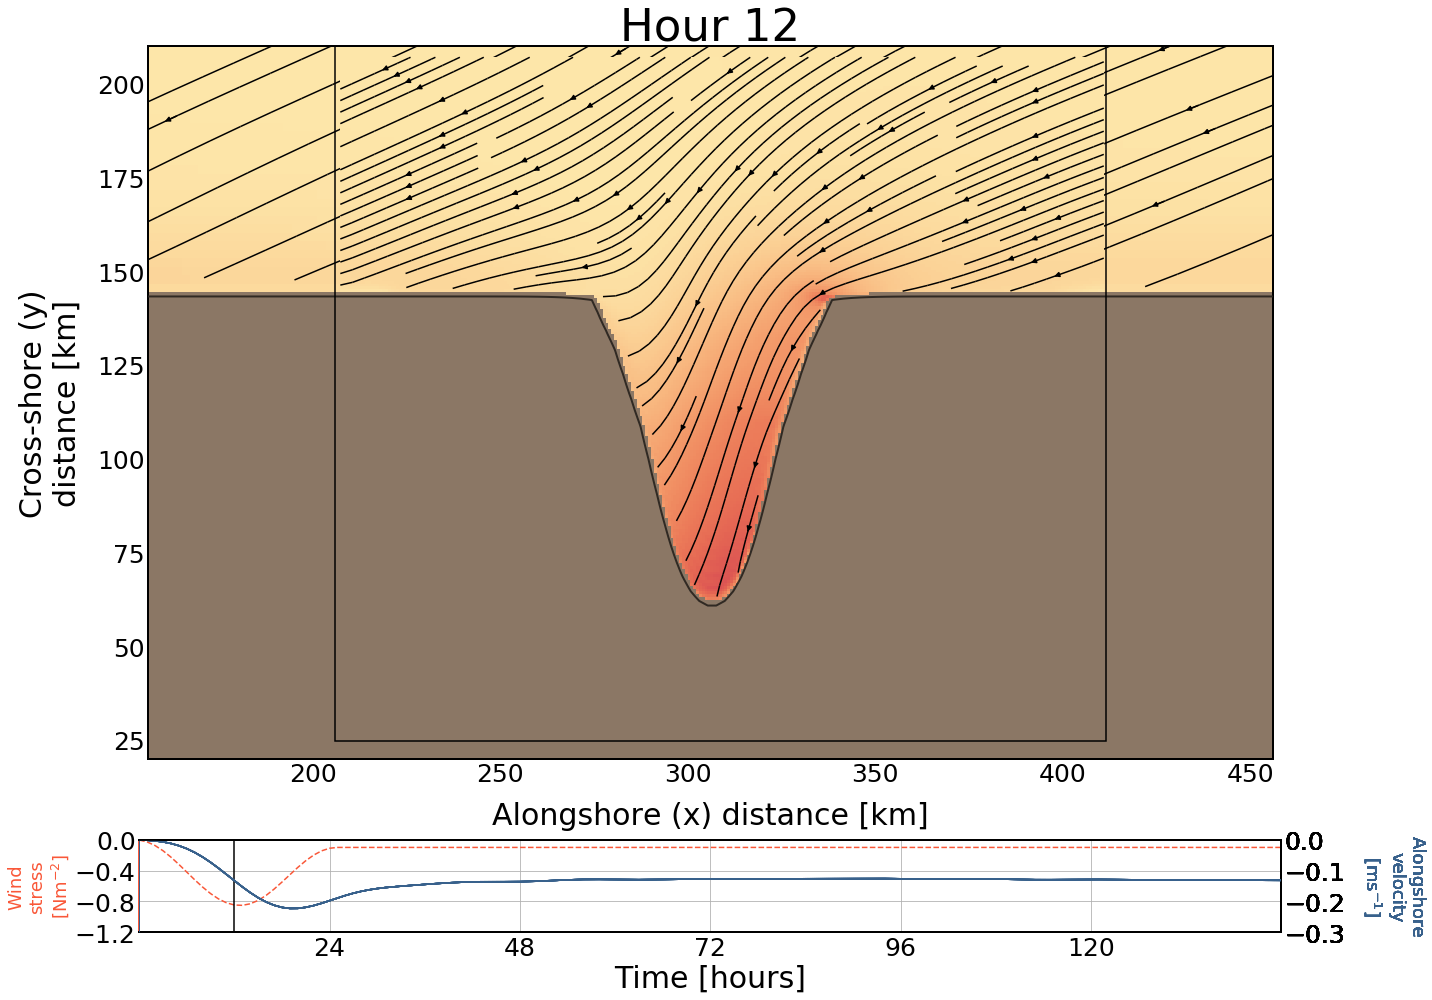

In [111]:
# fig, ax = plt.subplots(1,1,figsize=(18, 11))
fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[1,0.13])
ax = plt.subplot(gs[0,:])
axlong = plt.subplot(gs[1,:])
anim = animation.FuncAnimation(fig, animate, time_all_anim, blit=False, repeat=True)
anim.save('testt.mp4', writer=animation.FFMpegWriter(), dpi=100)